In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import OpenEXR as exr, Imath
from tqdm import tqdm
from glob import glob
import cv2

import torch
import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils.cloud import Cloud
from pose_est import PoseEst, create_rot_from_angle, transform_pc, extrinsics_from_rot_transl, get_params_from_rot_and_transl
from params_est import optim_step_ICP, optim_step_neighbors

In [35]:
depth_dir = f'../data/dpth/'
gt_extrinsics_dir = f'../data/gt_dpth/'
gt_depth_dir = '../data/gt_dpth/'
shared_K_path = f'../data/gt_dpth/K_0.txt'

# Testing denoising

## Input data

In [36]:
def load_data(depth_dir, gt_extrinsics_dir, indices, gt_depth_dir=None):
    # indices: array-like of int
    depth_all, RT_all, gt_depth_all = [], [], []
    for ind in indices:
        depth = np.load(os.path.join(depth_dir, f'{ind}.npy'))
        RT = np.loadtxt(os.path.join(gt_extrinsics_dir, f'RT_{ind}.txt'))
        depth_all.append(depth)
        RT_all.append(RT)
        if gt_depth_dir is not None:
            gt_depth = np.load(os.path.join(gt_depth_dir, f'{ind}.npy'))
            if len(gt_depth.shape) == 3 and gt_depth.shape[2] == 1:
                gt_depth = gt_depth[..., 0]
            gt_depth_all.append(gt_depth)
    
    depth_all = torch.tensor(np.stack(depth_all)).double()
    RT_all = torch.tensor(np.stack(RT_all)).double()
    if gt_depth_dir is not None:
        gt_depth_all = torch.tensor(np.stack(gt_depth_all)).double()
        return depth_all, RT_all, gt_depth_all
    return depth_all, RT_all

In [37]:
depth, extr, gt_depth = load_data(depth_dir, gt_extrinsics_dir, indices=[80, 90], gt_depth_dir=gt_depth_dir)
depth = depth.cuda()
extr = extr.cuda()
gt_depth = gt_depth.cuda()

depth = F.interpolate(depth.unsqueeze(0), scale_factor=1).squeeze()
gt_depth = F.interpolate(gt_depth.unsqueeze(0), scale_factor=1).squeeze()

d1 = gt_depth[0].clone()
d2 = gt_depth[1].clone()
d1[d1 != d1.max()] += (th.rand_like(d1[d1 != d1.max()]) - 0.5)*2/10*d1[d1 != d1.max()]

pc0 = Cloud.from_tensors(gt_depth[0].cuda(), K.cuda(), torch.eye(4).cuda(), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1].cuda(), K.cuda(), torch.eye(4).cuda(), ignore='max')

pc0_noisy = Cloud.from_tensors(d1.cuda(), K.cuda(), torch.eye(4).cuda(), ignore='max')
pc1_noisy = Cloud.from_tensors(d2.cuda(), K.cuda(), torch.eye(4).cuda(), ignore='max')

In [38]:
def loss_T(T_estim, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    loss_val = ((gt_rel_extr - T_estim) ** 2).sum()
    return loss_val

def loss_params(pred_params, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    gt_params = get_params_from_rot_and_transl(gt_rel_extr[:3, :3], gt_rel_extr[:3, 3])
    loss_val = ((pred_params - gt_params) ** 2).sum()
    return loss_val

def grad_depth(dpth):
    g_filters = th.zeros(2, 1, 3, 3).to(dpth)
    g_filters[0, 0, 0, 1] = 1
    g_filters[0, 0, 1, 1] = -1
    g_filters[1, 0, 1, 0] = 1
    g_filters[1, 0, 1, 1] = -1
    ret = F.conv2d(dpth[None, None, :, :], g_filters, padding=1).squeeze()
    return ret

def l1_depth(dpth):
    mask = dpth != dpth.max()
    mask = mask.unsqueeze(0).expand(2, -1, -1)
    grad = grad_depth(dpth)
    norm = th.norm(grad[mask], p=1)
    return norm

In [39]:
def perform_gradslam(pc0, pc1, gradslam_iter=10):
    T = torch.eye(4).double().cuda()
    for i in (range(gradslam_iter)):
        params_upd = optim_step_neighbors(pc0, pc1,
                                          lam_min=0.00001,
                                          lam_max=0.01,
                                          D=1,
                                          sigma=1e-4,
                                          max_iter=20,
                                          neighbors_take_each=1000, verbose=0)
        transl_upd, angle_upd = params_upd.split([3, 3], dim=-1)
        rot_upd = create_rot_from_angle(angle_upd.unsqueeze(0)).squeeze(0)
        pc0.points = transform_pc(pc0.points, rot_upd, transl_upd).squeeze(1)

        T_upd = extrinsics_from_rot_transl(rot_upd, transl_upd).double()
        T = T_upd @ T
        rot, transl = T[:3, :3], T[:3, 3]
        params = get_params_from_rot_and_transl(rot, transl)
        #print('loss', loss_params(params, extr[0], extr[1]))
    return params

In [33]:
d1.requires_grad = True
lam_norm = 1e-10
opt = optim.Adam([d1], lr=0.01, amsgrad=True)
loss_denoise = [F.mse_loss(d1.data, gt_depth[0]).cpu().numpy()]
print('Loss_denoise = ', loss_denoise[0])
loss_align = []
for i in range(100):
    pc0_noisy = Cloud.from_tensors(d1.cuda(), K.cuda(), torch.eye(4).cuda(), ignore='max')
    pc1_noisy = Cloud.from_tensors(d2.cuda(), K.cuda(), torch.eye(4).cuda(), ignore='max')
    print(pc0.points.shape)
    params = perform_gradslam(pc0_noisy, pc1_noisy, gradslam_iter=15)
    loss_val = loss_params(params, extr[0], extr[1])
    loss_tv = l1_depth(d1)*lam_norm
    loss_val = loss_val + loss_tv
    opt.zero_grad()
    loss_val.backward()
    opt.step()
    loss_align.append(loss_val.data.cpu().numpy())
    loss_denoise.append(F.mse_loss(d1.data, gt_depth[0]).cpu().numpy())
    print('Loss_align = ', loss_align[-1])
    print('Loss_TV = ', loss_tv.data.cpu().numpy())
    print('Loss_denoise = ', loss_denoise[-1])

Loss_denoise =  0.011741241878238435
torch.Size([147518, 3])
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Loss_align =  0.0030242917487292693
Loss_TV =  1.669327377014578e-05
Loss_denoise =  0.01172846988506117
torch.Size([147518, 3])
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not converge with required tolerance.
Did not conv

RuntimeError: CUDA out of memory. Tried to allocate 2.28 GiB (GPU 0; 10.92 GiB total capacity; 6.17 GiB already allocated; 1.83 GiB free; 2.34 GiB cached)

## Without TV regularization

Text(0.5, 0, 'Iteration number')

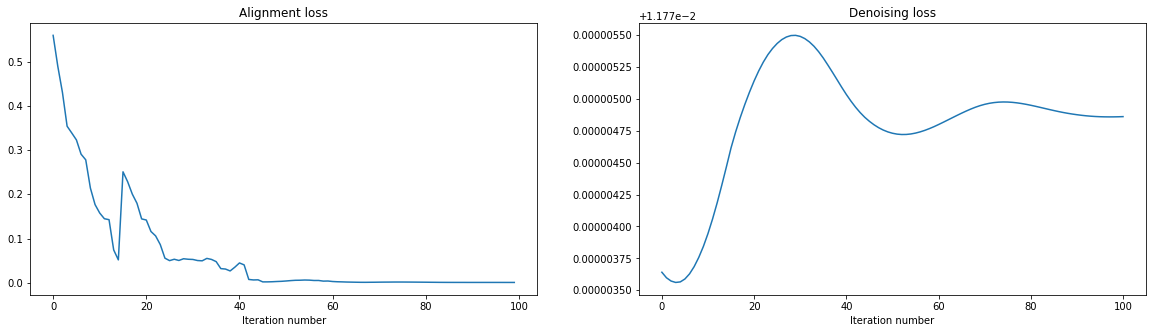

In [415]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax[0].plot(loss_align)
ax[0].set_title('Alignment loss')
ax[0].set_xlabel('Iteration number')

ax[1].plot(loss_denoise)
ax[1].set_title('Denoising loss')
ax[1].set_xlabel('Iteration number')

## With TV regularization

Text(0.5, 0, 'Iteration number')

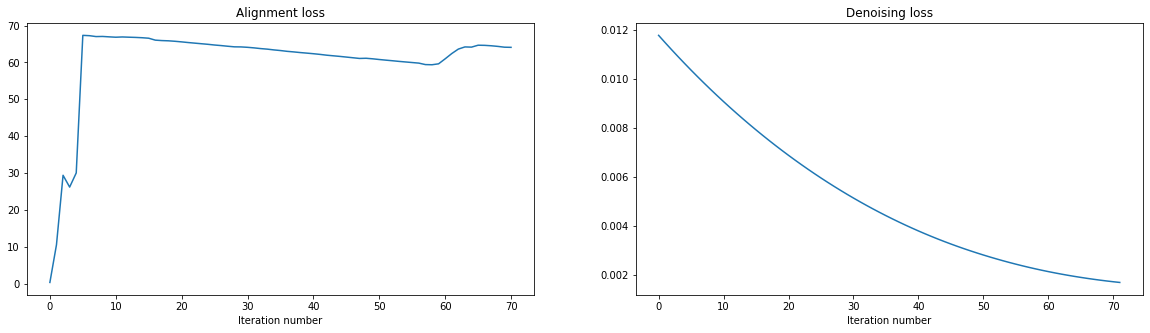

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax[0].plot(loss_align)
ax[0].set_title('Alignment loss')
ax[0].set_xlabel('Iteration number')

ax[1].plot(loss_denoise)
ax[1].set_title('Denoising loss')
ax[1].set_xlabel('Iteration number')